In [ ]:
!wget https://zenodo.org/records/6496656/files/pathmnist.npz

--2023-12-16 12:42:06--  https://zenodo.org/records/6496656/files/pathmnist.npz
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205615438 (196M) [application/octet-stream]
Saving to: ‘pathmnist.npz’

pathmnist.npz       100%[===================>] 196.09M  16.4MB/s    in 13s     

2023-12-16 12:42:20 (15.1 MB/s) - ‘pathmnist.npz’ saved [205615438/205615438]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from urllib.parse import urlsplit
import re
import cv2

from tabulate import tabulate
pd.set_option('display.max_columns', None)

from tqdm import tqdm
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from glob import glob
import seaborn as sns
from tabulate import tabulate
import random
import os
from tqdm import tqdm
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet, InceptionV3, VGG16, ResNet50
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import EarlyStopping

#importing metrics for model evaluation
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score,recall_score,f1_score,roc_auc_score,roc_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')


import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the .npz file
data = np.load('pathmnist.npz')

# get the data & labels
X_train = data['train_images']
X_val = data['val_images']
X_test = data['test_images']

y_train = data['train_labels'].flatten()
y_val = data['val_labels'].flatten()
y_test = data['test_labels'].flatten()

# Display shapes of the arrays
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (89996, 28, 28, 3)
X_val shape: (10004, 28, 28, 3)
X_test shape: (7180, 28, 28, 3)
y_train shape: (89996,)
y_val shape: (10004,)
y_test shape: (7180,)


In [ ]:
# Select a random subset of images
num_images_to_display = 6000
random_indices = np.random.choice(len(X_train), num_images_to_display, replace=False)
X_train = X_train[random_indices]
y_train = y_train[random_indices]

num_images_to_display = 2000
random_indices = np.random.choice(len(X_val), num_images_to_display, replace=False)
X_val = X_val[random_indices]
y_val = y_val[random_indices]

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (6000, 28, 28, 3)
X_val shape: (2000, 28, 28, 3)


In [ ]:
height = 224
width = 224

In [ ]:
def resize_and_convert(images, new_shape=(224, 224)):
    resized_images = []
    for img in tqdm(images, desc='Processing'):
        if img.shape[-1] == 3:
          # Resize the image to the new shape
          resized = cv2.resize(img, new_shape)
          resized_images.append(resized)
    return np.array(resized_images)

# Resize and convert images in X_train, X_test, X_val
X_train_resized = resize_and_convert(X_train, new_shape=(height, width))
X_test_resized = resize_and_convert(X_test, new_shape=(height, width))
X_val_resized = resize_and_convert(X_val, new_shape=(height, width))

Processing: 100%|██████████| 2000/2000 [00:00<00:00, 15349.95it/s]


In [ ]:
# Normalise all the images
def normalize_images(images):
  # convert into float32
  images = images.astype('float32')
  images /= 255.0
  return images

In [ ]:
X_train_resized = normalize_images(X_train_resized)
X_test_resized = normalize_images(X_test_resized)
X_val_resized = normalize_images(X_val_resized)
print("done.")

done.


In [ ]:
X_train_resized.shape

(6000, 224, 224, 3)

In [ ]:
from keras.utils import to_categorical

# Perform one-hot encoding on labels
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
y_val_one_hot = to_categorical(y_val)

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)
# fitting
datagen.fit(X_train_resized)

In [ ]:
height, width, channel = (224,224,3)

Classes = [f"Tissue_{i}" for i in range(9)]
Classes

['Tissue_0',
 'Tissue_1',
 'Tissue_2',
 'Tissue_3',
 'Tissue_4',
 'Tissue_5',
 'Tissue_6',
 'Tissue_7',
 'Tissue_8']

In [ ]:
def LoadPretrainedModel(MODEL):
  # Load the pre-trained model
  pretrained_model = MODEL(weights='imagenet', include_top=False, input_shape=(height, width, channel))

  # Freeze the pre-trained layers to prevent their weights from being updated during training
  for layer in pretrained_model.layers:
      layer.trainable = False

  # Create a new model by adding your custom layers on top of the model
  model = tf.keras.Sequential([
      pretrained_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(len(Classes), activation='softmax')
  ])

  # Compile and summarize the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

## InceptionV3

In [ ]:
def TrainModel(model, X_train, y_train, X_test, y_test, epochs, batch_size, early_stopping, verbose):
  # Train the model with early stopping on train data and validate on test data
  history = model.fit(datagen.flow(X_train, y_train,
                                    batch_size=batch_size), epochs=epochs,verbose=verbose,validation_data=(X_test, y_test), callbacks=[early_stopping],
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    workers=4)
  return history

In [ ]:
EPOCHS = 20
BATCH_SIZE = 16

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
model_InceptionV3 = LoadPretrainedModel(InceptionV3)
history = TrainModel(model_InceptionV3, X_train_resized, y_train_one_hot, X_val_resized, y_val_one_hot, EPOCHS, BATCH_SIZE, early_stopping, verbose = 1)

Epoch 1/20
375/375 [==============================] - 39s 82ms/step - loss: 1.0683 - accuracy: 0.6292 - val_loss: 0.6850 - val_accuracy: 0.7650
Epoch 2/20
375/375 [==============================] - 25s 65ms/step - loss: 0.7670 - accuracy: 0.7333 - val_loss: 0.6376 - val_accuracy: 0.7765
Epoch 3/20
375/375 [==============================] - 23s 61ms/step - loss: 0.6964 - accuracy: 0.7570 - val_loss: 0.5505 - val_accuracy: 0.8015
Epoch 4/20
375/375 [==============================] - 23s 62ms/step - loss: 0.6554 - accuracy: 0.7775 - val_loss: 0.5809 - val_accuracy: 0.7940
Epoch 5/20
375/375 [==============================] - 23s 62ms/step - loss: 0.6177 - accuracy: 0.7780 - val_loss: 0.5210 - val_accuracy: 0.8145
Epoch 6/20
375/375 [==============================] - 24s 63ms/step - loss: 0.5991 - accuracy: 0.7932 - val_loss: 0.5171 - val_accuracy: 0.8120
Epoch 7/20
375/375 [==============================] - 23s 60ms/step - loss: 0.5858 - accuracy: 0.7940 - val_loss: 0.5315 - val_accuracy:

In [ ]:
def plotGraphs(history):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range=range(len(history.history['loss']))

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

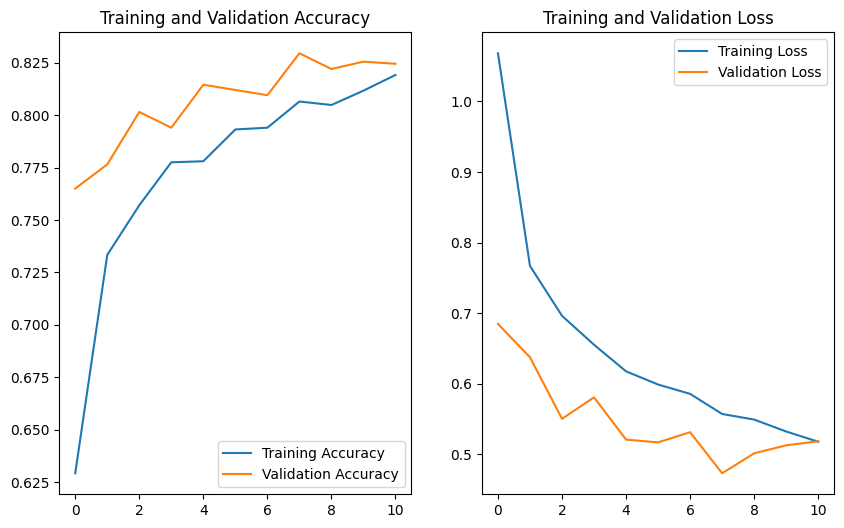

In [ ]:
plotGraphs(history)

In [ ]:
def predict_deep_learning_model(model, X_test, y_test, model_name):

  '''
  Pass the model and predict value.
  Function will calculate all the eveluation metrics and appending those metrics score on model_result table.
  Plotting confusion_matrix and roc_curve for test data.
  '''

  # predicting value and probability
  # prediction on testing data
  y_test_prob = model.predict(X_test)
  y_test_pred = np.argmax(np.round(y_test_prob), axis=1)


  # y_test_prob = model.predict(X_test)


  ''' Performance Metrics '''
  # accuracy score  ---->  TP+TN/TP+FP+TN+FN
  test_accuracy = accuracy_score(y_test, y_test_pred)
  print(f'Accuracy : {round(test_accuracy,3)}')

  # precision score  ---->  TP/TP+FP
  test_precision = precision_score(y_test, y_test_pred,average='macro')
  print(f'Precision : {round(test_precision,3)}')

  # recall score  ---->  TP/TP+FN
  test_recall = recall_score(y_test, y_test_pred,average='macro')
  print(f'Recall : {round(test_recall,3)}')

  # f1 score  ---->  Harmonic Mean of Precision and Recall
  test_f1 = f1_score(y_test, y_test_pred,average='macro')
  print(f'F1-Score : {round(test_f1,3)}')



  # classificatio report
  print(f'classification report for test data \n{classification_report(y_test, y_test_pred, target_names=Classes)}')
  print('-'*80)


  ''' plotting Confusion Matrix '''
  fig, ax = plt.subplots(figsize=(7,5))
  ConfusionMatrixDisplay.from_predictions(y_test_pred, y_test,
                                            ax=ax,
                                            display_labels=Classes,
                                            xticks_rotation='vertical')
  plt.title(f'confusion matrix on Test data ({model_name})', weight='bold')
  plt.show()
  print('-'*80)


  # appneding performance metrics score to make final model_result.
  return pd.DataFrame([{'model':model_name,
                       'Accuracy':test_accuracy,
                       'Precision':test_precision,
                       'Recall':test_recall,
                       'F1-Score':test_f1}])

In [ ]:
path = '/content/drive/MyDrive/MNIST_RES'
InceptionV3_res.to_csv(path+"/"+"InceptionV3_res.csv")

## MobileNet

Epoch 1/20
375/375 [==============================] - 29s 68ms/step - loss: 0.9158 - accuracy: 0.6692 - val_loss: 0.6352 - val_accuracy: 0.7755
Epoch 2/20
375/375 [==============================] - 20s 54ms/step - loss: 0.6058 - accuracy: 0.7822 - val_loss: 0.5107 - val_accuracy: 0.8155
Epoch 3/20
375/375 [==============================] - 21s 55ms/step - loss: 0.5276 - accuracy: 0.8118 - val_loss: 0.4893 - val_accuracy: 0.8300
Epoch 4/20
375/375 [==============================] - 20s 52ms/step - loss: 0.4866 - accuracy: 0.8253 - val_loss: 0.4731 - val_accuracy: 0.8345
Epoch 5/20
375/375 [==============================] - 20s 54ms/step - loss: 0.4638 - accuracy: 0.8352 - val_loss: 0.4345 - val_accuracy: 0.8420
Epoch 6/20
375/375 [==============================] - 20s 52ms/step - loss: 0.4492 - accuracy: 0.8367 - val_loss: 0.4861 - val_accuracy: 0.8360
Epoch 7/20
375/375 [==============================] - 20s 53ms/step - loss: 0.4059 - accuracy: 0.8530 - val_loss: 0.4698 - val_accuracy:

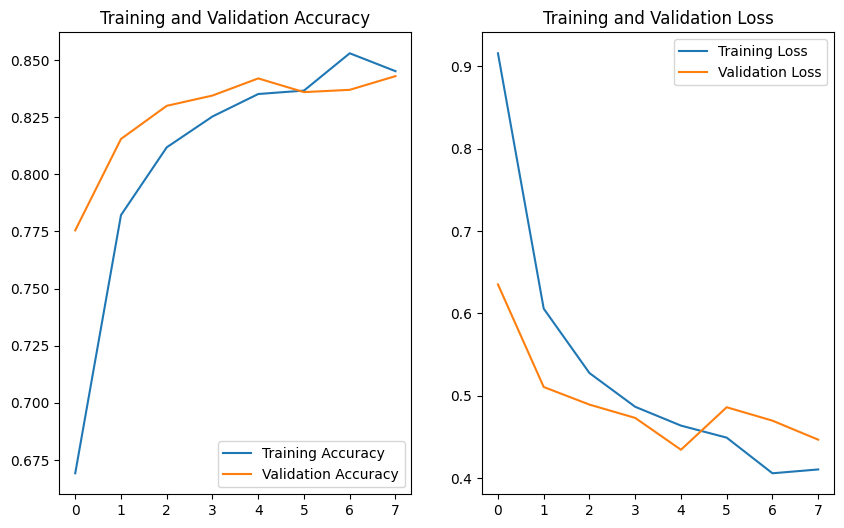

In [ ]:
model_MobileNet = LoadPretrainedModel(MobileNet)
history1 = TrainModel(model_MobileNet, X_train_resized, y_train_one_hot, X_val_resized, y_val_one_hot, EPOCHS, BATCH_SIZE, early_stopping, verbose = 1)
plotGraphs(history1)

In [ ]:
path = '/content/drive/MyDrive/MNIST_RES'
MobileNet_res.to_csv(path+"/"+"MobileNet_res.csv")

In [ ]:
def save_model(model, filename):
    model.save(filename)

In [ ]:
# Save the trained model
save_model(model_MobileNet, '/content/drive/MyDrive/MNIST_RES/mobilenet_trained_model_pathMNIST.h5')

## Models Evaluation

In [ ]:
models_pd = pd.concat([InceptionV3_res, MobileNet_res]).reset_index(drop=True).round(3)
print(models_pd)

         model  Accuracy  Precision  Recall  F1-Score
0  InceptionV3     0.802      0.796   0.753     0.762
1    MobileNet     0.846      0.818   0.803     0.805


## Train Machine Learning Models

In [ ]:
from keras.models import load_model

# Load the saved model
loaded_best_model = load_model('/content/drive/MyDrive/MNIST_RES/mobilenet_trained_model_pathMNIST.h5')

In [ ]:
def features_extraction_cnn(best_model):
  # Freeze the pre-trained layers to prevent their weights from being updated during training
  for layer in best_model.layers:
      layer.trainable = False

  feature_extractor_train = best_model.predict(X_train_resized, verbose=0)
  feature_extractor_test = best_model.predict(X_test_resized, verbose=0)

  features_train = feature_extractor_train.reshape(feature_extractor_train.shape[0], -1)
  features_test = feature_extractor_test.reshape(feature_extractor_test.shape[0], -1)

  # Create a DataFrame from the reshaped features
  df_train = pd.DataFrame(data=features_train, columns=[f'feature_{i+1}' for i in range(features_train.shape[1])])
  df_test = pd.DataFrame(data=features_test, columns=[f'feature_{i+1}' for i in range(features_test.shape[1])])

  return df_train, df_test

In [ ]:
loaded_best_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
train_df, test_df = features_extraction_cnn(loaded_best_model)

In [ ]:
train_df['Output'] = y_train
train_df['data'] = 'training'

test_df['Output'] = y_test
test_df['data'] = 'test'

In [ ]:
final_dataset = pd.concat([train_df, test_df])
final_dataset.shape

(13180, 50178)

In [ ]:
XX = final_dataset.drop(['Output', 'data'], axis = 1)
yy = final_dataset[['Output', 'data']]

In [ ]:
from sklearn.decomposition import PCA


# Create a PCA instance with the desired explained variance ratio
desired_variance_ratio = 0.95
pca = PCA(n_components=desired_variance_ratio)

# Fit PCA on the features
pca.fit(XX)

# Transform the features using PCA
reduced_features = pca.transform(XX)

# Create a DataFrame from the reduced features
reduced_features_df = pd.DataFrame(data=reduced_features, columns=[f'PC{i+1}' for i in range(reduced_features.shape[1])])

# Print the number of retained features
num_retained_features = reduced_features.shape[1]
print(f"Number of retained features after reduction: {num_retained_features}")

Number of retained features after reduction: 6113


In [ ]:
df_pca = pd.DataFrame(reduced_features, columns=[f'pca_{i+1}' for i in range(num_retained_features)])
df_pca.head()

pca_1      pca_2      pca_3      pca_4      pca_5      pca_6     pca_7  \
0  56.319012 -14.712935   3.456712  -7.092424  25.250141  12.431064 -8.986872   
1  40.719204 -28.446712  45.513657  13.267443 -26.689171 -12.446239 -7.403221   
2 -73.624405 -64.051346   4.529805 -17.881012   6.276604   1.250848 -6.496013   
3 -75.340782 -62.102890   6.796780 -31.370682  21.967148 -12.880292 -4.154344   
4  70.245453 -22.147463  33.112972 -10.732038  -6.818279  -6.391537  0.955719   

       pca_8      pca_9     pca_10     pca_11     pca_12     pca_13  \
0 -13.058056  22.167953 -28.371626 -10.004722   4.680892 -17.891369   
1 -11.462458   9.484144  24.339008 -23.514822  -0.247446   3.637901   
2 -10.138880   4.641597  -3.547990  16.497749  -3.392087  -3.225818   
3   7.285607  -7.493872  -0.720926  -2.670022  -6.595588  -6.854235   
4 -10.691995   5.815619  -4.434921  -0.796651  14.454535  -2.936137   

      pca_14     pca_15     pca_16     pca_17    pca_18     pca_19     pca_20  \
0   0.408876 -11.523233 -20.742258   6.942312  2.233752   0.122304   4.295351   
1  -5.976525   5.745185   7.187185 -12.472067 -7.323013   5.586689 -18.037039   
2  -4.059183  -3.176913   5.602458  -5.979595  4.997952  25.605026   9.459366   
3  -2.085857  -0.373486  -5.299932  -0.633755 -1.566120   5.843746   6.849267   
4  12.637850 -20.459684  -0.579334  10.260383 -0.022040  13.190485 -10.973464   

      pca_21     pca_22     pca_23     pca_24     pca_25    pca_26    pca_27  \
0  -1.860149  -2.539539  -9.523293  -4.394532  -2.660901  6.484966 -0.131539   
1   3.499464  -4.375723  12.877921 -10.157771  -6.782128  0.514828 -0.097857   
2  -0.469227   4.216241   1.573478  -3.564877 -11.880741 -0.842217 -4.480793   
3   0.927956 -10.214983   5.911610  -4.476169  -0.028501  3.024867 -1.282899   
4  13.957302  -5.757532 -16.731308 -11.637223   3.730331 -6.865273 -2.776176   

      pca_28     pca_29     pca_30     pca_31    pca_32    pca_33     pca_34  \
0   1.833566 -10.096520   5.301842  -7.182216  5.505056 -2.828153  -4.185482   
1   9.068551 -18.370462   1.967387  -6.592690 -7.427923 -4.589952  -6.088499   
2  -9.026485   4.489276   0.679665  -3.368305  0.177837  1.779873  -2.980336   
3   3.424445   0.449400   1.040322  -3.858374 -2.075179 -1.779762  -5.534803   
4 -11.921205   0.575180  20.891907  23.270517 -0.891368 -8.529372  12.988398   

      pca_35    pca_36    pca_37     pca_38    pca_39    pca_40     pca_41  \
0   3.148450 -3.417577  6.377286  -2.184097 -0.718707  7.359873  -2.272962   
1   5.736190  0.432447 -7.756209  -0.275385 -4.072504 -2.771104   8.009389   
2  -2.434859  6.563121  2.775864  11.235355  4.749440 -2.179217  -2.090802   
3  -0.714385  0.422720 -0.931356   1.234475 -2.191168 -6.778070   8.141940   
4  13.825039 -7.805512 -8.468719  -1.838560 -2.907347 -6.468631 -16.151484   

     pca_42    pca_43     pca_44    pca_45    pca_46     pca_47    pca_48  \
0  8.180408  2.432768  15.837110  3.742431 -7.877848 -11.190348  8.993895   
1  4.429263  4.186037  -0.720297 -8.504060  5.964933   5.775315  1.258048   
2 -0.774336 -1.188843   2.881531  2.824589 -0.963410  -0.084838 -0.353618   
3  0.171833  0.254409   4.654086 -1.022029  3.243823   3.484656  1.296291   
4 -2.368883  5.506674   4.369065  6.678040  3.332125  -4.259959  5.128109   

     pca_49     pca_50     pca_51     pca_52    pca_53     pca_54     pca_55  \
0 -8.581387  -0.843333   5.420638  10.070090  6.918652 -12.120133  -8.027567   
1 -2.313512   1.386305   9.310295 -11.086764  8.046083   4.394360 -12.987640   
2  1.097443  -0.750549   0.102663   4.481891 -2.216664   4.763983  -5.500140   
3 -3.154347   2.743905  -1.786302  -0.157766  0.995003  -4.932710   1.593115   
4 -6.739445  10.682117 -12.593759   3.221025  1.743191   4.662242  11.790241   

      pca_56     pca_57    pca_58    pca_59     pca_60    pca_61    pca_62  \
0  -3.881968  10.273947  9.072341  0.612585 -11.280489 -0.147019  6.485798   
1  -1.720144   4.199111 -7.156748  2.842065   6.912959 -6.567260  8.205653 

In [ ]:
df_pca[['Output', 'data']] = final_dataset[['Output', 'data']].values

In [ ]:
df_pca.to_csv("/content/drive/MyDrive/MNIST_RES/pca_features_pathMNIST.csv", index=False)

In [ ]:
df_train = df_pca[df_pca['data']=='training']
df_test = df_pca[df_pca['data']=='test']

XX_train, yy_train = df_train.drop(['Output', 'data'], axis = 1), df_train['Output']
XX_val, yy_val= df_test.drop(['Output', 'data'], axis = 1), df_test['Output']
XX_train.shape, XX_val.shape

((6000, 6113), (7180, 6113))

In [ ]:
yy_train = yy_train.astype(int)
yy_val = yy_val.astype(int)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [ ]:
def predict_ml_model(ml_model,X_train, y_train, X_test, y_test, model_name):

  '''
  Pass the model and predict value.
  Function will calculate all the eveluation metrics and appending those metrics score on model_result table.
  Plotting confusion_matrix and roc_curve for test data.
  '''

  # model fitting
  model = ml_model.fit(X_train, y_train)

  # predicting value and probability
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)


  ''' Performance Metrics '''
  # accuracy score  ---->  TP+TN/TP+FP+TN+FN
  train_accuracy = accuracy_score(y_train, y_train_pred)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  print(f'train accuracy : {round(train_accuracy,3)}')
  print(f'test accuracy : {round(test_accuracy,3)}')

  # precision score  ---->  TP/TP+FP
  test_precision = precision_score(y_test, y_test_pred,average='macro')
  print(f'test precision : {round(test_precision,3)}')

  # recall score  ---->  TP/TP+FN
  test_recall = recall_score(y_test, y_test_pred,average='macro')
  print(f'test recall : {round(test_recall,3)}')

  # f1 score  ---->  Harmonic Mean of Precision and Recall
  test_f1 = f1_score(y_test, y_test_pred,average='macro')
  print(f'test f1 : {round(test_f1,3)}')


  # classificatio report
  print(f'classification report for test data \n{classification_report(y_test, y_test_pred)}')
  print('-'*80)


  ''' plotting Confusion Matrix '''
  ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
  plt.title('confusion matrix on Test data', weight='bold')
  plt.show()
  print('-'*80)


  # appneding performance metrics score to make final model_result.
  return pd.DataFrame([{'model':model_name,
                       'Training accuracy':train_accuracy,
                       'Testing Accuracy':test_accuracy,
                       'Precision':test_precision,
                       'Recall':test_recall,
                       'F1-Score':test_f1}])

In [ ]:
models_pd = pd.concat([lr_res, lr_res1]).reset_index(drop=True)
models_pd

,model,Training accuracy,Testing Accuracy,Precision,Recall,F1-Score
0,DecisionTreeRegressor,1.0,0.529805,0.486242,0.477221,0.474298
1,LogisticRegression,1.0,0.852786,0.802099,0.812351,0.805910


In [ ]:
def plot_performance_metrics_graph(models_pd):
  plt.figure(figsize=(13, 6))

  index = np.arange(len(models_pd['model']))
  bar_width = 0.2

  accuracy = plt.bar(index, models_pd['Testing Accuracy'], bar_width, label='Testing Accuracy', color='skyblue')
  precision = plt.bar(index + bar_width, models_pd['Precision'], bar_width, label='Precision', color='orange')
  recall = plt.bar(index + 2 * bar_width, models_pd['Recall'], bar_width, label='Recall', color='green')
  f1 = plt.bar(index + 3 * bar_width, models_pd['F1-Score'], bar_width, label='F1', color='red')

  # Add text labels to each bar
  def autolabel(rects):
      for rect in rects:
          height = rect.get_height()
          plt.text(rect.get_x() + rect.get_width() / 2., height, '{:.3f}%'.format(height),
                  ha='center', va='bottom', fontsize=8)

  # Customize the plot
  autolabel(accuracy)
  autolabel(precision)
  autolabel(recall)
  autolabel(f1)

  plt.xlabel('Model')
  plt.ylabel('Score')
  plt.title('Performance Metrics for Different Models')
  plt.xticks(index + 2 * bar_width, models_pd['model'], rotation=45)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.tight_layout()
  plt.xticks(rotation=90)
  plt.savefig('overall.png')
  plt.show()

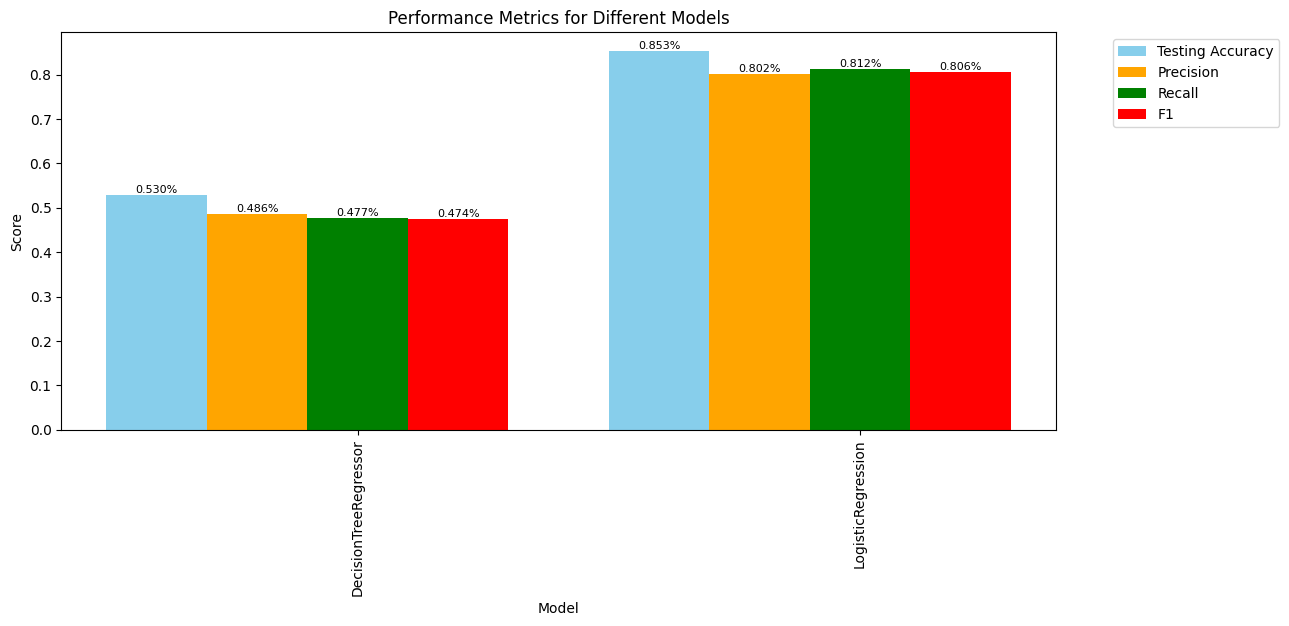

In [ ]:
plot_performance_metrics_graph(models_pd)